In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Any other package, please import at here:
import pandas as pd
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
import cvxpy as cp
import datetime
import pyfolio as pf

In [14]:
# 讀取CSV文件
df_price = pd.read_csv("Q3_data.csv")

# 將 'Date' 列轉換為 datetime 對象，並將其設置為索引
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price = df_price.set_index('Date')

# 選取 'Adj Close' 列，並且將每個標的名稱設置為列名
df_price = df_price.pivot(columns='Symbol', values='Adj Close')

# 使用 resample 找到每個月最後一個交易日的數據
df_price = df_price.resample('BM').last()
df_price = df_price.dropna(axis=1)
df_price_SPY = pd.DataFrame(df_price['SPY'])


returns = df_price.pct_change()
returns = returns.dropna(axis=0)
returns_SPY = pd.DataFrame(returns['SPY'])

df_price = df_price.drop(columns = 'SPY')
returns = returns.drop(columns = 'SPY')

# 計算前三個月的平均報酬
returns_rolling = returns.rolling(window=3).mean().dropna()

# 建立一個存放每月權重的DataFrame
weights = pd.DataFrame(index=returns_rolling.index, columns=returns.columns)

# 建立一個存放每月投資組合報酬的Series
portfolio_returns = pd.Series(index=returns_rolling.index, dtype='float64')

# 設定起始日期
start_date = datetime.datetime(2001, 1, 1)

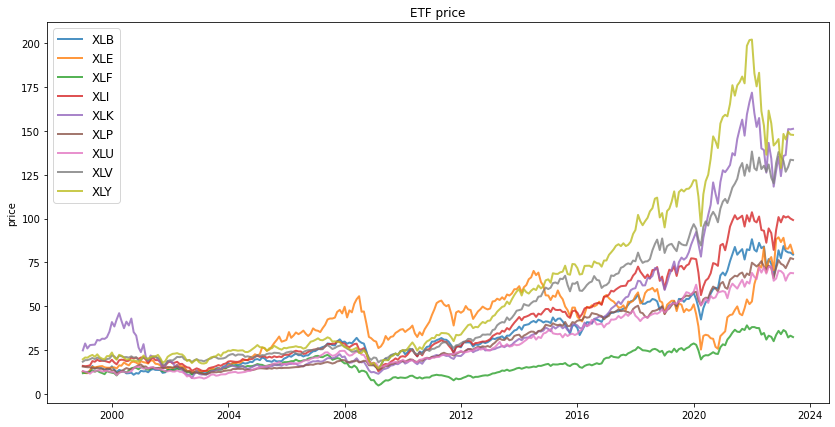

In [15]:
# 看一下ETF價格走勢
plt.figure(figsize=(14, 7))
for column in df_price.columns:
    plt.plot(df_price.index, df_price[column], lw=2, alpha=0.8, label=column)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price')
plt.title('ETF price')
plt.show()

# 嘗試Min Risk資產配置組合

In [16]:
# 資產配置
for date in returns_rolling.index:
    # 如果日期在起始日期之後，則進行處理
    if date >= start_date:
        try:
            # 提取前三個月當月的收益
            three_months_prior = date - pd.DateOffset(months=3)
            ret = returns.loc[three_months_prior:date - pd.DateOffset(days=1)]

            # 計算協方差矩陣和期望收益
            cov_matrix = ret.cov()
            expected_ret = ret.mean()

            # 定義優化問題
            num_assets = len(ret.columns)
            w = cp.Variable(num_assets)
            risk = cp.quad_form(w, cov_matrix.values)
            prob = cp.Problem(cp.Minimize(risk), 
                              [cp.sum(w) == 1, 
                               w >= 0])

            # 解決優化問題
            prob.solve()

            # 儲存權重
            weights.loc[date] = w.value

            # 將weights和returns都移動一個月，這樣我們就可以用每月底的權重去乘以下個月的收益率
            weights_shifted = weights.shift(1)
            portfolio_returns = (weights_shifted * returns).sum(axis=1)
        except:
            continue

Total return: 3.22


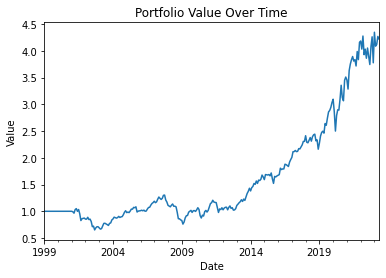

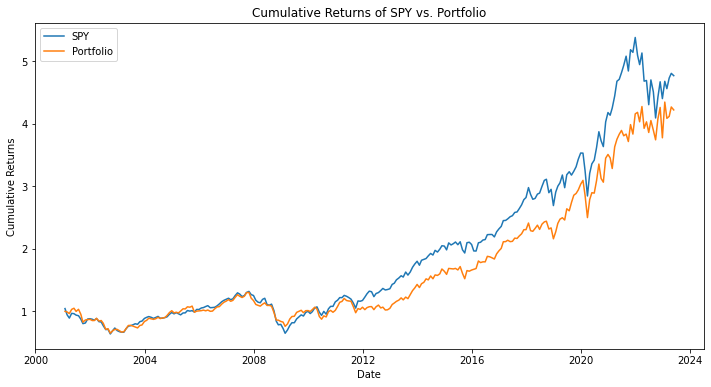

In [17]:
# 查看績效
# Calculate the total return of the portfolio
total_return = (1 + portfolio_returns).prod() - 1
print(f'Total return: {total_return:.2f}')

# Calculate the portfolio value over time
portfolio_value = (1 + portfolio_returns).cumprod()

# Plot the portfolio value over time
portfolio_value.plot()
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# 篩選出從投資開始日期後的SPY回報
returns_SPY = returns_SPY.loc[start_date:]

# 計算SPY的累積回報
cumulative_returns_SPY = (1 + returns_SPY).cumprod()

# 計算投資組合的累積回報
cumulative_returns_portfolio = (1 + portfolio_returns.loc[start_date:]).cumprod()

# Plot the cumulative returns of SPY and the portfolio
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns_SPY, label='SPY')
plt.plot(cumulative_returns_portfolio, label='Portfolio')
plt.title('Cumulative Returns of SPY vs. Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# 資產配置尚不能超越SPY Buy and hold
## 改進方式: 更新資產配置最佳化問題
    1. 平均分配權重投資所有ETF
    2. 每次重新資產配置時，僅考慮前3個月平均月報酬前五名之ETF做為更新資產配置考慮。其他排名在前5以後資產配置設為0。

## 方法1: Equal Weight資產配置策略
### 勝過SPY Buy and Hold

In [18]:
# 確定資產類別的數量
n_assets = len(weights.columns)

# 將每個資產類別的權重設置為均等值
equal_weights = 1 / n_assets

# 將整個權重 DataFrame 更新為均衡資產配置
weights.loc[:, :] = equal_weights

portfolio_returns = (weights * returns).sum(axis=1)

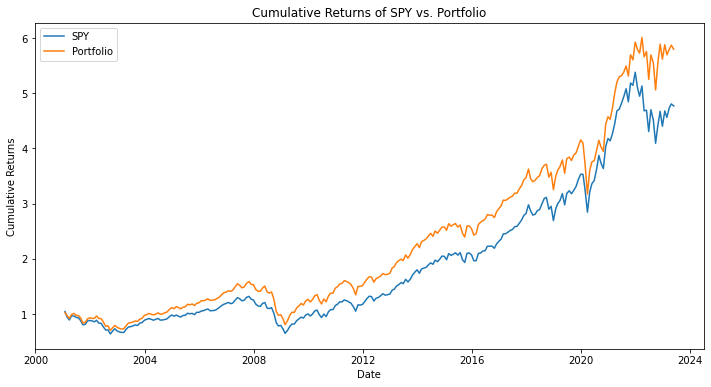

In [19]:
# 篩選出從投資開始日期後的SPY回報
returns_SPY = returns_SPY.loc[start_date:]

# 計算SPY的累積回報
cumulative_returns_SPY = (1 + returns_SPY).cumprod()

# 計算投資組合的累積回報
cumulative_returns_portfolio = (1 + portfolio_returns.loc[start_date:]).cumprod()

# Plot the cumulative returns of SPY and the portfolio
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns_SPY, label='SPY')
plt.plot(cumulative_returns_portfolio, label='Portfolio')
plt.title('Cumulative Returns of SPY vs. Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

## 方法2: 加入10年期美國公債，做效率前緣資產配置¶
### 勝過SPY Buy and Hold

In [20]:
# 讀取CSV文件
df_price = pd.read_csv("Q3_data.csv")
df_US10Yyield = pd.read_csv("IRLTLT01USM156N.csv")

# 將 'Date' 列轉換為 datetime 對象，並將其設置為索引
df_price['Date'] = pd.to_datetime(df_price['Date'])
df_price = df_price.set_index('Date')
df_US10Yyield['DATE'] = pd.to_datetime(df_US10Yyield['DATE'])
df_US10Yyield = df_US10Yyield.set_index('DATE')
df_US10Yyield['IRLTLT01USM156N'] = pd.to_numeric(df_US10Yyield['IRLTLT01USM156N'], errors='coerce')
df_US10Yyield = df_US10Yyield['IRLTLT01USM156N'].div(100)  # convert to decimal
df_US10Yyield = df_US10Yyield.resample('BM').last()  # align with df_price
df_US10Yyield = df_US10Yyield / 12  # convert to monthly rate

# 選取 'Adj Close' 列，並且將每個標的名稱設置為列名
df_price = df_price.pivot(columns='Symbol', values='Adj Close')

# 使用 resample 找到每個月最後一個交易日的數據
df_price = df_price.resample('BM').last()
df_price = df_price.dropna(axis=1)
df_price_SPY = pd.DataFrame(df_price['SPY'])

returns = df_price.pct_change()
returns = returns.dropna(axis=0)
returns_SPY = pd.DataFrame(returns['SPY'])

df_price = df_price.drop(columns = 'SPY')
returns = returns.drop(columns = 'SPY')

# 建立一個存放每月權重的DataFrame
weights = pd.DataFrame(index=returns.index, columns=returns.columns)

# 建立一個存放每月投資組合報酬的Series
portfolio_returns = pd.Series(index=returns.index, dtype='float64')

# 設定起始日期
start_date = datetime.datetime(2001, 1, 1)

for date in returns.index:
    # 如果日期在起始日期之後，則進行處理
    if date >= start_date:
        try:
            # 初始化所有ETF權重為零
            weights.loc[date] = 0.0
    
            # 提取前三個月月報酬
            three_months_prior = date - pd.DateOffset(months=2)
            ret = returns.loc[three_months_prior:date]
    
            # 計算前三個月平均月報酬並選擇前五檔做為標的
            expected_ret = ret.mean()
            top_five = expected_ret.nlargest(5)
            
            # 提取選定標的的過去三個月月報酬和協方差
            ret_selected = ret[top_five.index]
            cov_matrix = ret_selected.cov()
            
            # 定義優化問題
            num_assets = len(ret_selected.columns)
            w = cp.Variable(num_assets)
            
            # 新增無風險利率的考量，並根據效率前緣理論進行資產配置
            rf_rate = df_US10Yyield.loc[date]
            expected_ret_adj = returns.loc[date,top_five.index] - rf_rate
            objective = cp.Maximize(w @ expected_ret_adj.values - 0.5 * cp.quad_form(w, cov_matrix.values))
            
            # 增加一個限制條件，讓權重都大於一個非常小的正數
            constraints = [cp.sum(w) == 1, w >= 1e-6]
            
            prob = cp.Problem(objective, constraints)
            
            # 解決優化問題
            prob.solve(solver=cp.SCS)
            
            # 檢查問題是否成功解決
            if prob.status != 'optimal':
                print(f"Problem not solved: {prob.status}")
            else:
                # 儲存權重
                weights.loc[date, top_five.index] = w.value
            
                # 處理權重小於0的情況
                weights[weights < 0] = 1e-6
            
                # 處理最大的權重
                max_weight = weights.loc[date, top_five.index].max()
                weights.loc[date, top_five.index] = np.where(weights.loc[date, top_five.index] == max_weight,
                                                             1 - (weights.loc[date, top_five.index].sum() - max_weight),
                                                             weights.loc[date, top_five.index])
            
                # 將weights和returns都移動一個月，這樣我們就可以用每月底的權重去乘以下個月的收益率
                weights_shifted = weights.shift(1)
                portfolio_returns = (weights_shifted * returns).sum(axis=1)
        except:
            continue


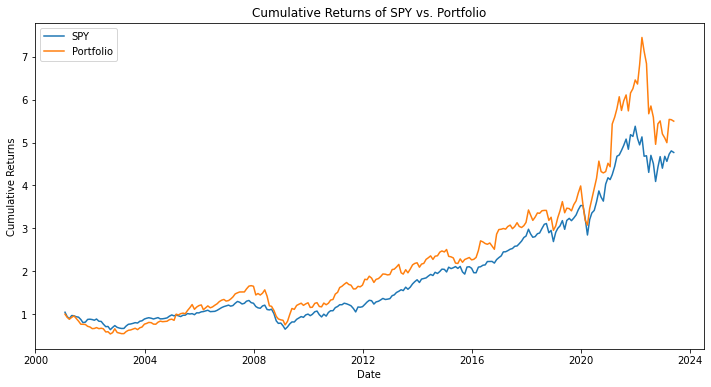

In [21]:
# 篩選出從投資開始日期後的SPY回報
returns_SPY = returns_SPY.loc[start_date:]

# 計算SPY的累積回報
cumulative_returns_SPY = (1 + returns_SPY).cumprod()

# 計算投資組合的累積回報
cumulative_returns_portfolio = (1 + portfolio_returns.loc[start_date:]).cumprod()

# Plot the cumulative returns of SPY and the portfolio
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns_SPY, label='SPY')
plt.plot(cumulative_returns_portfolio, label='Portfolio')
plt.title('Cumulative Returns of SPY vs. Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

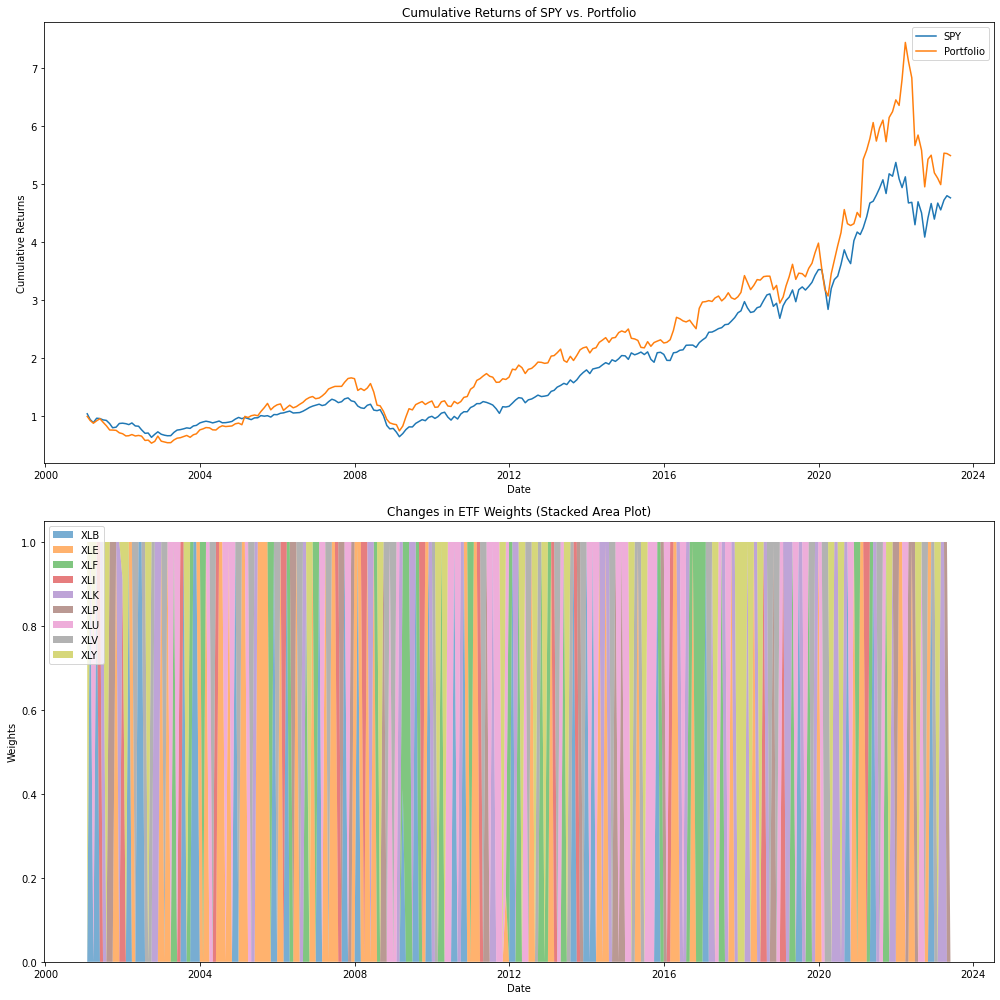

In [22]:
# 輸出投組價值&權重
weights = weights.astype(float)
fig, axs = plt.subplots(2, 1, figsize=(14,14)) # Creates a grid of 2 rows, 1 column

# Plot the cumulative returns of SPY and the portfolio
axs[0].plot(cumulative_returns_SPY, label='SPY')
axs[0].plot(cumulative_returns_portfolio, label='Portfolio')
axs[0].set_title('Cumulative Returns of SPY vs. Portfolio')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Cumulative Returns')
axs[0].legend()

# Plot the changes in ETF weights
axs[1].stackplot(weights.index, weights.T.values, labels=weights.columns, alpha=0.6)
axs[1].legend(loc='upper left')
axs[1].set_title('Changes in ETF Weights (Stacked Area Plot)')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Weights')

plt.tight_layout() # Improves appearance
plt.show()